In [1]:

import pandas as pd

#Loading the Flight level Data
df = pd.read_csv(r"Flight Level Data.csv")

# Doing the conversion for date-time columns to proper datetime format
df['scheduled_departure_datetime_local'] = pd.to_datetime(df['scheduled_departure_datetime_local'], errors='coerce')
df['actual_departure_datetime_local'] = pd.to_datetime(df['actual_departure_datetime_local'], errors='coerce')

# Computing departure delay in minutes
df['departure_delay_min'] = (df['actual_departure_datetime_local'] - df['scheduled_departure_datetime_local']).dt.total_seconds() / 60

# Key EDA metrics for Flight Delay calculation
avg_delay = df['departure_delay_min'].mean()
late_flights = (df['departure_delay_min'] > 0).sum()
total_flights = df['departure_delay_min'].notna().sum()
percent_late = (late_flights / total_flights) * 100

# Output
print(f"Total Flights Analyzed: {total_flights}")
print(f"Average Departure Delay: {avg_delay:.2f} minutes")
print(f"Flights Departed Late: {late_flights} ({percent_late:.2f}%)")


Total Flights Analyzed: 8099
Average Departure Delay: 21.18 minutes
Flights Departed Late: 4018 (49.61%)


Matplotlib is building the font cache; this may take a moment.


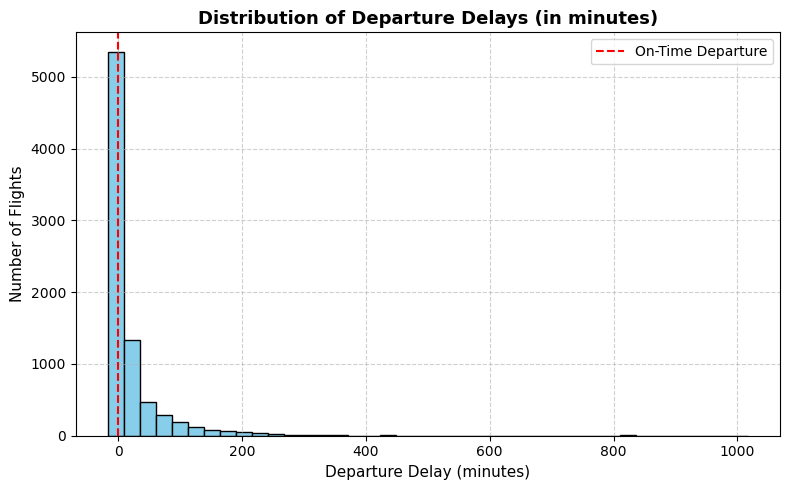

In [2]:
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_csv(r"Flight Level Data.csv")


df['scheduled_departure_datetime_local'] = pd.to_datetime(df['scheduled_departure_datetime_local'], errors='coerce')
df['actual_departure_datetime_local'] = pd.to_datetime(df['actual_departure_datetime_local'], errors='coerce')

# Departure Delay calculation in minutes
df['departure_delay_min'] = (df['actual_departure_datetime_local'] - df['scheduled_departure_datetime_local']).dt.total_seconds() / 60

# Plotin histogram for departure delays 
plt.figure(figsize=(8,5))
plt.hist(df['departure_delay_min'].dropna(), bins=40, color='skyblue', edgecolor='black')
plt.title('Distribution of Departure Delays (in minutes)', fontsize=13, fontweight='bold')
plt.xlabel('Departure Delay (minutes)', fontsize=11)
plt.ylabel('Number of Flights', fontsize=11)
plt.axvline(x=0, color='red', linestyle='--', label='On-Time Departure')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [3]:
import pandas as pd


df = pd.read_csv(r"Flight Level Data.csv")

# Converting numeric columns safely
df['scheduled_ground_time_minutes'] = pd.to_numeric(df['scheduled_ground_time_minutes'], errors='coerce')
df['minimum_turn_minutes'] = pd.to_numeric(df['minimum_turn_minutes'], errors='coerce')

# Defining categories
below_min = df[df['scheduled_ground_time_minutes'] < df['minimum_turn_minutes']]
close_to_min = df[
    (df['scheduled_ground_time_minutes'] >= df['minimum_turn_minutes']) &
    (df['scheduled_ground_time_minutes'] <= df['minimum_turn_minutes'] + 5)
]
comfortable = df[df['scheduled_ground_time_minutes'] > df['minimum_turn_minutes'] + 5]

# Calculating for each category 
print("Total Flights Analyzed:", len(df))
print("Flights scheduled BELOW minimum turn time:", len(below_min))
print("Flights scheduled WITHIN 5 mins above minimum:", len(close_to_min))
print("Flights scheduled comfortably above minimum:", len(comfortable))

# Optional: Add a column flag for further analysis
def classify_turn(row):
    if pd.isna(row['scheduled_ground_time_minutes']) or pd.isna(row['minimum_turn_minutes']):
        return 'Unknown'
    elif row['scheduled_ground_time_minutes'] < row['minimum_turn_minutes']:
        return 'Below Minimum'
    elif row['scheduled_ground_time_minutes'] <= row['minimum_turn_minutes'] + 5:
        return 'Close to Minimum'
    else:
        return 'Comfortable'

df['turn_category'] = df.apply(classify_turn, axis=1)

# Preview with turn_category
df[['company_id','flight_number','scheduled_ground_time_minutes','minimum_turn_minutes','turn_category']].sample(10, random_state=101)
                                                                                                            


Total Flights Analyzed: 8099
Flights scheduled BELOW minimum turn time: 630
Flights scheduled WITHIN 5 mins above minimum: 150
Flights scheduled comfortably above minimum: 7319


,company_id,flight_number,scheduled_ground_time_minutes,minimum_turn_minutes,turn_category
383,G7,4436,49,33,Comfortable
155,G7,4518,44,29,Comfortable
4915,UA,2862,66,56,Comfortable
1207,UA,1306,480,56,Comfortable
6808,UA,1857,59,60,Below Minimum
4372,UA,118,0,75,Below Minimum
4800,OO,5125,43,29,Comfortable
6736,OO,5601,110,29,Comfortable
7777,UA,1209,60,56,Close to Minimum
3847,UA,2329,102,43,Comfortable


In [4]:
import pandas as pd
import numpy as np


bags = pd.read_csv(r"Bag+Level+Data.csv")

# Cleaning and modifying the data
bags['bag_type'] = bags['bag_type'].astype(str).str.strip().str.title()

# Identifing checked (origin) and transfer (Hot + normal) bags ---
bags['is_checked']  = (bags['bag_type'] == 'Origin').astype(int)
bags['is_transfer'] = bags['bag_type'].isin(['Transfer', 'Hot Transfer']).astype(int)

# Parsing dates
if 'scheduled_departure_date_local' in bags.columns:
    bags['scheduled_departure_date_local'] = pd.to_datetime(
        bags['scheduled_departure_date_local'], format='%d-%m-%Y', errors='coerce'
    ).dt.date

# Grouping by flight (company, flight no, date)
group_cols = ['company_id', 'flight_number']
if 'scheduled_departure_date_local' in bags.columns:
    group_cols.append('scheduled_departure_date_local')

bag_stats = bags.groupby(group_cols).agg(
    checked_bags=('is_checked', 'sum'),
    transfer_bags=('is_transfer', 'sum')
).reset_index()

# Defining cases
case1 = bag_stats[(bag_stats['checked_bags'] > 0) & (bag_stats['transfer_bags'] > 0)].copy()
case2 = bag_stats[(bag_stats['checked_bags'] == 0) & (bag_stats['transfer_bags'] > 0)].copy()
case3 = bag_stats[(bag_stats['checked_bags'] > 0) & (bag_stats['transfer_bags'] == 0)].copy()

# Calculating ratio for Case 1 (only valid where checked > 0)
case1['transfer_to_checked_ratio'] = case1['transfer_bags'] / case1['checked_bags']

# Computing the ratio
avg_ratio_case1 = case1['transfer_to_checked_ratio'].mean()
num_case1, num_case2, num_case3 = len(case1), len(case2), len(case3)
total_flights = len(bag_stats)

print("Total Flights Analyzed:", total_flights)
print("Case 1 ➜ Checked > 0 & Transfer > 0 :", num_case1, "flights")
print("Case 2 ➜ Checked = 0 & Transfer > 0 :", num_case2, "flights")
print("Case 3 ➜ Checked > 0 & Transfer = 0 :", num_case3, "flights")
print("Average Transfer-to-Checked Ratio (Case 1):", round(avg_ratio_case1, 2))

# --- Optional: preview few flights per case ---
print("Case 1 sample:")
print(case1.sample(10, random_state=101)[['company_id', 'flight_number', 'checked_bags', 'transfer_bags', 'transfer_to_checked_ratio']])

print("Case 2 sample:")
print(case2.sample(10, random_state=101)[['company_id', 'flight_number', 'checked_bags', 'transfer_bags']])

print("Case 3 sample:")
print(case3.sample(10, random_state=101)[['company_id', 'flight_number', 'checked_bags', 'transfer_bags']])


Total Flights Analyzed: 10269
Case 1 ➜ Checked > 0 & Transfer > 0 : 8345 flights
Case 2 ➜ Checked = 0 & Transfer > 0 : 1895 flights
Case 3 ➜ Checked > 0 & Transfer = 0 : 29 flights
Average Transfer-to-Checked Ratio (Case 1): 3.76
Case 1 sample:
      company_id  flight_number  checked_bags  transfer_bags  \
4423          OO           5806             9             10   
7587          UA           1795            64             19   
10158         YX           3685            10             50   
2666          OO           4791             1             23   
1875          G7           4549             1             34   
10005         YX           3610            20             19   
2948          OO           5125            24             29   
4637          OO           5901             8             46   
8251          UA           2100            45             65   
8330          UA           2138            30             28   

       transfer_to_checked_ratio  
4423           

Passenger Load Summary:
count    8107.000000
mean      128.366720
std        77.750497
min         1.000000
25%        57.000000
50%       120.000000
75%       186.000000
max       530.000000
Name: pax_count, dtype: float64
Correlation (Passenger Load vs Departure Delay): -0.02
Correlation (Passenger Load vs Ground Time Margin): 0.06


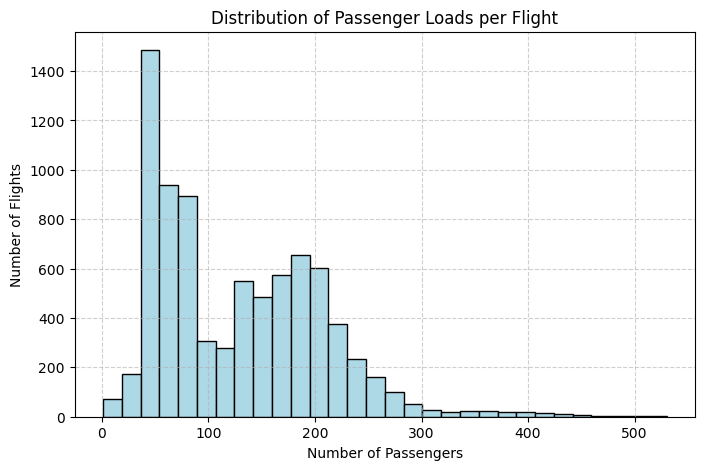

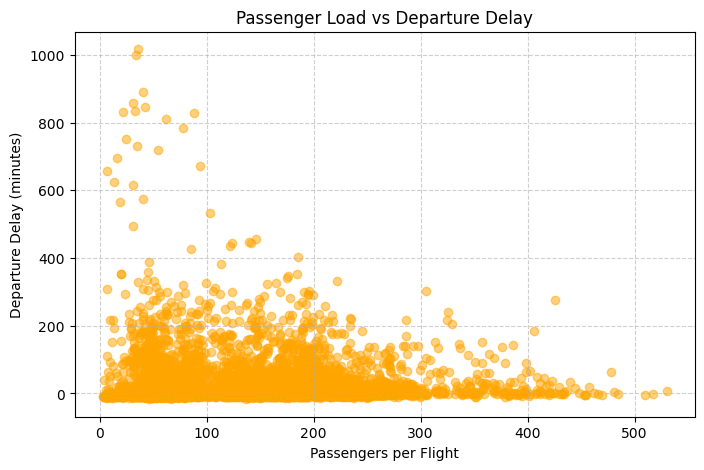

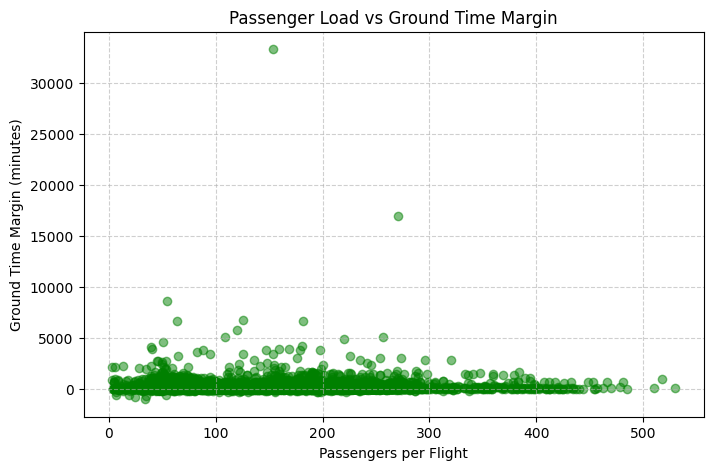

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Using these 2 datasets to merge and get the overlapping data available
pnr = pd.read_csv(r"PNR+Flight+Level+Data.csv")
flights = pd.read_csv(r"Flight Level Data.csv")

# Date Columns
pnr['scheduled_departure_date_local'] = pd.to_datetime(pnr['scheduled_departure_date_local'], errors='coerce').dt.date
flights['scheduled_departure_datetime_local'] = pd.to_datetime(flights['scheduled_departure_datetime_local'], errors='coerce')
flights['actual_departure_datetime_local'] = pd.to_datetime(flights['actual_departure_datetime_local'], errors='coerce')
flights['scheduled_departure_date_local'] = flights['scheduled_departure_datetime_local'].dt.date

# Passenger load per flight per day 
pax_loads = pnr.groupby(['company_id', 'flight_number', 'scheduled_departure_date_local'])['total_pax'].sum().reset_index(name='pax_count')

# Merging with operational data 
merged = pax_loads.merge(flights, on=['company_id', 'flight_number', 'scheduled_departure_date_local'], how='left')

# Computing operational difficulty proxies/metrics
merged['departure_delay_min'] = (merged['actual_departure_datetime_local'] - merged['scheduled_departure_datetime_local']).dt.total_seconds() / 60
merged['ground_time_margin'] = merged['scheduled_ground_time_minutes'] - merged['minimum_turn_minutes']

# statistics
print("Passenger Load Summary:")
print(merged['pax_count'].describe())

# Correlation analysis 
corr_delay = merged[['pax_count', 'departure_delay_min']].corr().iloc[0,1]
corr_ground = merged[['pax_count', 'ground_time_margin']].corr().iloc[0,1]

print(f"Correlation (Passenger Load vs Departure Delay): {corr_delay:.2f}")
print(f"Correlation (Passenger Load vs Ground Time Margin): {corr_ground:.2f}")

# --- Visualization 1: Passenger Load Distribution ---
plt.figure(figsize=(8,5))
plt.hist(merged['pax_count'], bins=30, color='lightblue', edgecolor='black')
plt.title('Distribution of Passenger Loads per Flight')
plt.xlabel('Number of Passengers')
plt.ylabel('Number of Flights')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# --- Visualization 2: Passenger Load vs Departure Delay ---
plt.figure(figsize=(8,5))
plt.scatter(merged['pax_count'], merged['departure_delay_min'], alpha=0.5, color='orange')
plt.title('Passenger Load vs Departure Delay')
plt.xlabel('Passengers per Flight')
plt.ylabel('Departure Delay (minutes)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# --- Visualization 3: Passenger Load vs Ground Time Margin ---
plt.figure(figsize=(8,5))
plt.scatter(merged['pax_count'], merged['ground_time_margin'], alpha=0.5, color='green')
plt.title('Passenger Load vs Ground Time Margin')
plt.xlabel('Passengers per Flight')
plt.ylabel('Ground Time Margin (minutes)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


SSR counts (flight_number x pnr_creation_date): (17650, 3)
Passenger loads shape: (8071, 4)
Flight delays shape: (8099, 4)
Merged dataset shape (after filtering pax_count>0): (8107, 7)

Pearson correlation between SSR rate and departure delay: -0.017

SSR category counts:
               count
ssr_category       
No SSR         7413
High SSR        347
Low SSR         347

Average metrics by SSR category:
ssr_category  flights    avg_pax  avg_ssr_rate  avg_delay  median_delay
    High SSR      347 111.985591      1.839661  18.340058          -1.0
     Low SSR      347 213.000000      0.521388  17.002882           2.0
      No SSR     7413 125.171860      0.000000  21.514247           0.0


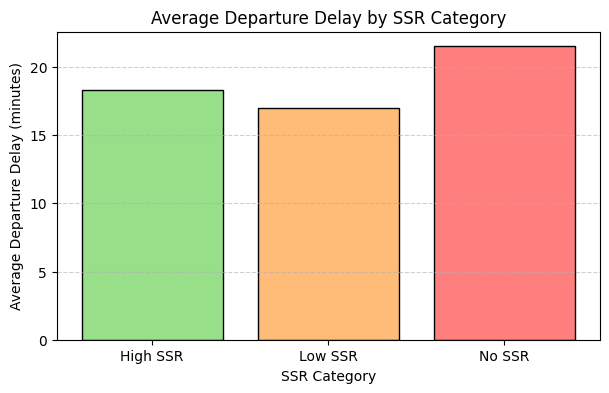

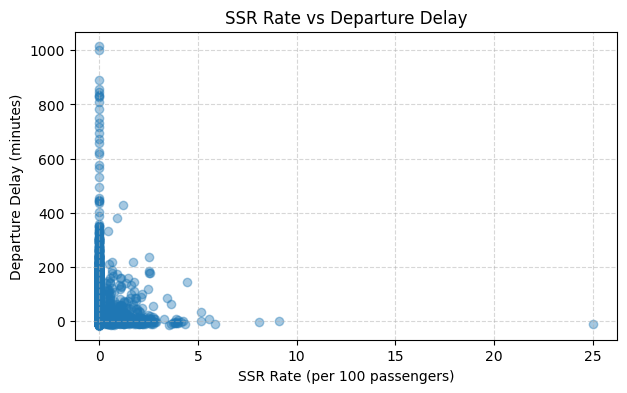


Done.


In [6]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


remarks_path = r"PNR Remark Level Data.csv"
pnr_path     = r"PNR+Flight+Level+Data.csv"
flights_path = r"Flight Level Data.csv"


# Loading remarks and flagging the 3 SSR types 
remarks = pd.read_csv(remarks_path)

# Confirm columns exist
expected_cols = ['record_locator', 'pnr_creation_date', 'flight_number', 'special_service_request']
missing = [c for c in expected_cols if c not in remarks.columns]
if missing:
    raise KeyError(f"Expected columns missing in remarks file: {missing}")


remarks['special_service_request_norm'] = remarks['special_service_request'].astype(str).str.strip().str.lower()

ssr_types = [
    'airport wheelchair',
    'manual wheelchair',
    'unaccompanied minor'
]

# Flagging rows containing any of these exact phrases (or containing them as substring)
def is_target_ssr(s):
    s = (s or "").lower()
    return int(any(t in s for t in ssr_types))

remarks['is_ssr'] = remarks['special_service_request_norm'].apply(is_target_ssr)

# Using pnr_creation_date as the date for grouping
remarks['pnr_creation_date'] = pd.to_datetime(remarks['pnr_creation_date'], errors='coerce').dt.date

# Aggregating SSR counts per flight_number + pnr_creation_date
ssr_counts = remarks.groupby(['flight_number', 'pnr_creation_date'])['is_ssr'].sum().reset_index().rename(columns={'is_ssr':'ssr_count'})
print("SSR counts (flight_number x pnr_creation_date):", ssr_counts.shape)

# Passenger loads (pax_count)
pnr = pd.read_csv(pnr_path)


pnr_date_col = next((c for c in pnr.columns if 'scheduled_departure' in c.lower() or 'flight_date' in c.lower() or 'date' in c.lower()), None)
if pnr_date_col is None:
    raise KeyError("Could not find a date column in PNR file.")
pnr[pnr_date_col] = pd.to_datetime(pnr[pnr_date_col], errors='coerce').dt.date


if 'total_pax' not in pnr.columns:
    raise KeyError("PNR file missing 'total_pax' column.")

# Aggregating passenger counts per company_id + flight_number + date
pnr['total_pax'] = pd.to_numeric(pnr['total_pax'], errors='coerce').fillna(0)
pax_loads = pnr.groupby(['company_id', 'flight_number', pnr_date_col])['total_pax'].sum().reset_index().rename(columns={'total_pax':'pax_count'})
print("Passenger loads shape:", pax_loads.shape)

# Flight delays 
fl = pd.read_csv(flights_path)

# Scheduled and actual departure datetime columns
sched_col = next((c for c in fl.columns if 'scheduled_departure' in c.lower() and 'datetime' in c.lower()), None)
actual_col = next((c for c in fl.columns if 'actual_departure' in c.lower() and 'datetime' in c.lower()), None)
if sched_col is None:
    raise KeyError("Could not find scheduled_departure_datetime column in FlightLevelData.csv")

fl[sched_col] = pd.to_datetime(fl[sched_col], errors='coerce')
if actual_col:
    fl[actual_col] = pd.to_datetime(fl[actual_col], errors='coerce')
    fl['departure_delay_min'] = (fl[actual_col] - fl[sched_col]).dt.total_seconds() / 60.0
else:
    
    delay_col = next((c for c in fl.columns if 'dep_delay' in c.lower() or 'departure_delay' in c.lower() or c.lower()=='delay'), None)
    fl['departure_delay_min'] = pd.to_numeric(fl[delay_col], errors='coerce') if delay_col else np.nan

fl['scheduled_departure_date_local'] = fl[sched_col].dt.date

# Preparing delays table for merge
delays = fl[['company_id', 'flight_number', 'scheduled_departure_date_local', 'departure_delay_min']]
print("Flight delays shape:", delays.shape)

# Merging datasets 
# Merging pax_loads with ssr_counts using flight_number + date (remarks use pnr_creation_date)
merged = pax_loads.merge(
    ssr_counts,
    left_on=['flight_number', pnr_date_col],
    right_on=['flight_number', 'pnr_creation_date'],
    how='left'
)

# Merging the delays (use company_id + flight_number + date)
merged = merged.merge(
    delays,
    left_on=['company_id','flight_number', pnr_date_col],
    right_on=['company_id','flight_number','scheduled_departure_date_local'],
    how='left'
)

# Filling missing SSR counts with 0
merged['ssr_count'] = merged['ssr_count'].fillna(0)

# Filter out rows with no passengers (avoid division by zero)
merged = merged[merged['pax_count'] > 0].copy()
print("Merged dataset shape (after filtering pax_count>0):", merged.shape)

# Computing SSR rate and robust bucketing
# SSR rate = SSRs per 100 passengers
merged['ssr_rate'] = (merged['ssr_count'] / merged['pax_count']) * 100.0

# Bucketing: No SSR, Low SSR, High SSR
no_ssr_mask = merged['ssr_rate'].fillna(0) == 0
positive_ssr = merged.loc[~no_ssr_mask, 'ssr_rate']

if len(positive_ssr) >= 2:
    median_val = positive_ssr.median()
    def ssr_label(r):
        if pd.isna(r) or r == 0:
            return 'No SSR'
        return 'Low SSR' if r <= median_val else 'High SSR'
    merged['ssr_category'] = merged['ssr_rate'].apply(ssr_label)
else:
    merged['ssr_category'] = merged['ssr_rate'].apply(lambda r: 'No SSR' if (pd.isna(r) or r==0) else 'Has SSR')


# correlation between ssr_rate and departure delay 
corr = merged[['ssr_rate','departure_delay_min']].corr().iloc[0,1]
print(f"\nPearson correlation between SSR rate and departure delay: {corr:.3f}")

# category counts and summary
cat_counts = merged['ssr_category'].value_counts().to_frame('count')
print("\nSSR category counts:\n", cat_counts)

summary = merged.groupby('ssr_category').agg(
    flights=('flight_number','count'),
    avg_pax=('pax_count','mean'),
    avg_ssr_rate=('ssr_rate','mean'),
    avg_delay=('departure_delay_min','mean'),
    median_delay=('departure_delay_min','median')
).reset_index()

print("\nAverage metrics by SSR category:")
print(summary.to_string(index=False))


# bar chart: average delay by SSR category
plt.figure(figsize=(7,4))
plt.bar(summary['ssr_category'], summary['avg_delay'], color=['#98df8a','#ffbb78','#ff7f7f'], edgecolor='black')
plt.title('Average Departure Delay by SSR Category')
plt.xlabel('SSR Category')
plt.ylabel('Average Departure Delay (minutes)')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# scatter: ssr_rate vs departure delay
plt.figure(figsize=(7,4))
plt.scatter(merged['ssr_rate'], merged['departure_delay_min'], alpha=0.4)
plt.xlabel('SSR Rate (per 100 passengers)')
plt.ylabel('Departure Delay (minutes)')
plt.title('SSR Rate vs Departure Delay')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

print("\nDone.")
